In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import jax
jax.config.update('jax_enable_x64',True)
from pathlib import Path

from jsindy.sindy_model import JSINDyModel
from jsindy.trajectory_model import DataAdaptedRKHSInterpolant
from jsindy.dynamics_model import FeatureLinearModel
from jsindy.optim import AlternatingActiveSetLMSolver, LMSettings

from exp.expdata import ExpData, LorenzExp
from exp.metrics import coeff_metrics, data_metrics
import pickle
import jax.numpy as jnp

import time
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
dt = 0.2
noise_var = 20
exp_data = LorenzExp
initial_state = jnp.array([ 0.37719066, -0.39631459, 16.92126795])
# sigma^2 - var
true_sigma2 = noise_var
t0=0
t1=10.1
n_train = len(jnp.arange(t0,t1,dt))

n_colloc = 500
expdata = exp_data(
    initial_state=initial_state,
    t0=t0,
    t1=t1,
    dt = 0.01,
    dt_train=dt,
    noise= jnp.sqrt(true_sigma2),
    seed=32,
    n_colloc=n_colloc,
    one_rkey=True,
    feature_names=['x','y','z']
)

trajectory_model = DataAdaptedRKHSInterpolant()
dynamics_model = FeatureLinearModel(reg_scaling = 1.)
optsettings = LMSettings(
    max_iter = 4000,
    show_progress=True,
    no_tqdm=False,
    min_alpha = 1e-16,
    init_alpha = 5.,
)
optimizer = AlternatingActiveSetLMSolver(
        beta_reg=0.001,
        solver_settings=optsettings,
        fixed_colloc_weight=50.,
        fixed_data_weight=1.,
        max_inner_iterations=500,
        )

model = JSINDyModel(
    trajectory_model=trajectory_model,
    dynamics_model=dynamics_model,
    optimizer=optimizer,
    feature_names=expdata.feature_names
)
model.fit(
    expdata.t_train,
    expdata.x_train,
    expdata.t_colloc
)

metrics = {}

metrics["coeff_mets"]  = coeff_metrics(
    coeff_est = model.theta.T,
    coeff_true = expdata.true_coeff
)

metrics["data_mets"] = data_metrics(
    pred_sim = model.predict(expdata.x_true),
    true = expdata.x_dot
)
metrics['model_params'] = model.params


  0%|          | 0/3000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

{'show_progress': True, 'sigma2_est': Array(1.00000044e-08, dtype=float64), 'data_weight': 1.0, 'colloc_weight': 50.0}
Warm Start


  0%|          | 0/4000 [00:00<?, ?it/s]

Iteration 0, loss = 2.176e+07, gradnorm = 5.796e+09, alpha = 5.0, improvement_ratio = 0.7274
Iteration 1, loss = 1.931e+07, gradnorm = 1.144e+10, alpha = 1.168e+03, improvement_ratio = 0.1126
Iteration 2, loss = 7.242e+06, gradnorm = 1.053e+10, alpha = 100.0, improvement_ratio = 0.625
Iteration 3, loss = 2.199e+06, gradnorm = 2.507e+10, alpha = 100.0, improvement_ratio = 0.6966
Iteration 4, loss = 1.744e+06, gradnorm = 3.886e+09, alpha = 100.0, improvement_ratio = 0.2073
Iteration 5, loss = 8.369e+05, gradnorm = 1.92e+10, alpha = 3.844e+03, improvement_ratio = 0.5216
Iteration 200, loss = 1.333e+03, gradnorm = 2.488e+06, alpha = 4.076, improvement_ratio = 0.4477
Iteration 400, loss = 1.301e+03, gradnorm = 5.574e+07, alpha = 1.965, improvement_ratio = 0.2779
Iteration 600, loss = 1.178e+03, gradnorm = 1.739e+07, alpha = 3.071, improvement_ratio = 0.5423
Iteration 800, loss = 1.029e+03, gradnorm = 3.134e+06, alpha = 0.5952, improvement_ratio = 0.8127
Iteration 1000, loss = 1.01e+03, grad

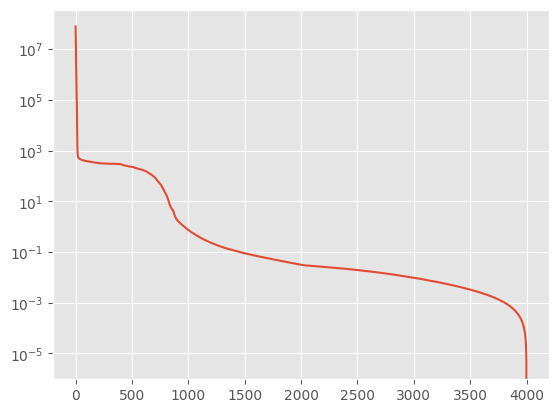

In [3]:
opt = model.opt_result[0]
plt.plot(opt.loss_vals - opt.loss_vals[-1])
plt.yscale('log')

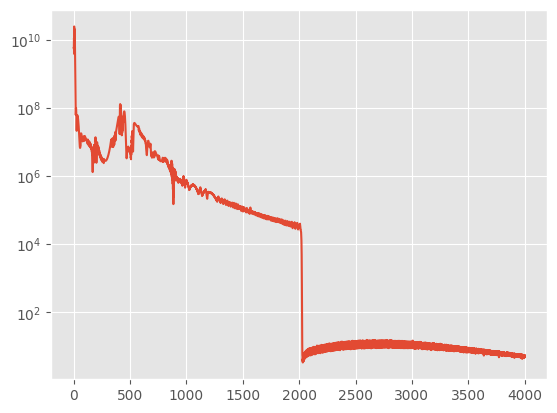

In [4]:
opt = model.opt_result[0]
plt.plot(opt.gradnorm)
plt.yscale('log')

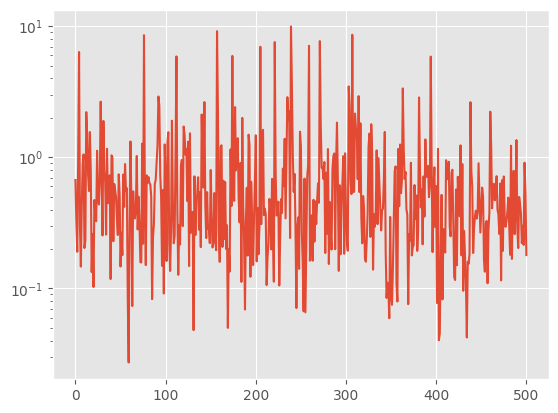

In [5]:
opt = model.opt_result[1]
plt.plot(opt.history['gnorms'][-1])
plt.yscale('log')

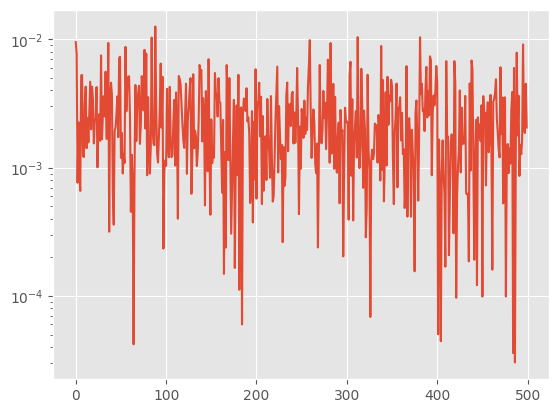

In [6]:
step_index = 5
plt.plot(-1*jnp.diff(jnp.array(opt.history['objval'][step_index])))
plt.yscale('log')

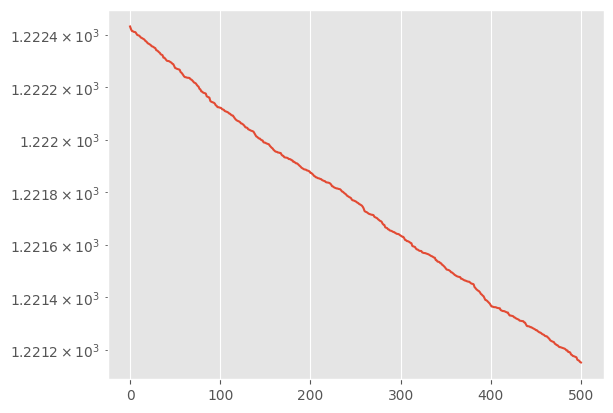

In [7]:
plt.plot(jnp.array(opt.history['objval'][step_index]))
plt.yscale('log')

In [8]:
model.print()

(x)' = 145.685 1 + -22.297 x + 21.250 y + -5.604 z
(y)' = -19.127 1 + 26.519 x + -0.944 x z
(z)' = 31.725 1 + -5.497 x + 2.140 y + -4.122 z + 0.974 x^2 + 0.454 x z + -0.334 y z


In [9]:
metrics

{'coeff_mets': {'precision': 0.35714285714285715,
  'recall': 0.7142857142857143,
  'f1': 0.47619047619047616,
  'coeff_rel_l2': 4.804567529855181,
  'coeff_rmse': 27.65738648076674,
  'coeff_mae': 8.002655298335068},
 'data_mets': {'mse': Array(2614.03312532, dtype=float64),
  'rmse': np.float64(51.12761607312652),
  'mae': np.float64(37.73676993455123),
  'max_abs_error': np.float64(212.23588501182394),
  'normalized_mse': Array(0.67192837, dtype=float64),
  'relative_l2_error': np.float64(0.8195816838050624)},
 'model_params': {'show_progress': True,
  'sigma2_est': Array(1.00000044e-08, dtype=float64),
  'data_weight': 1.0,
  'colloc_weight': 50.0}}

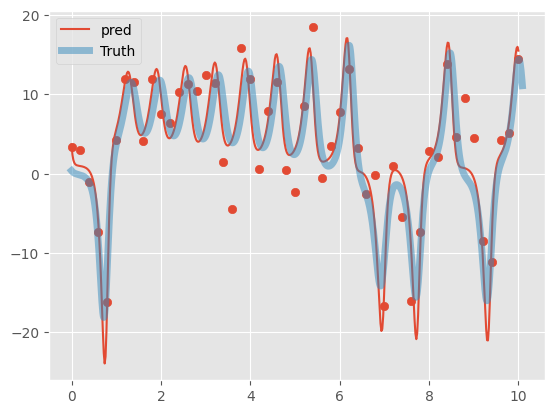

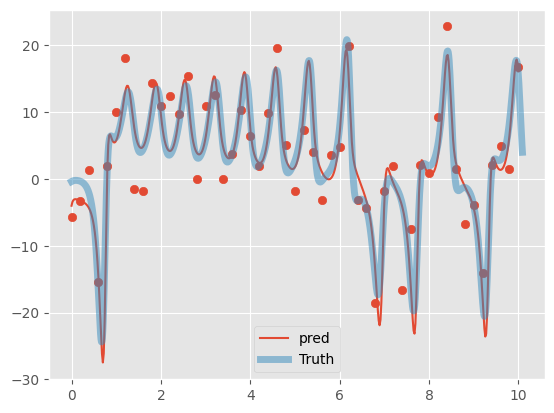

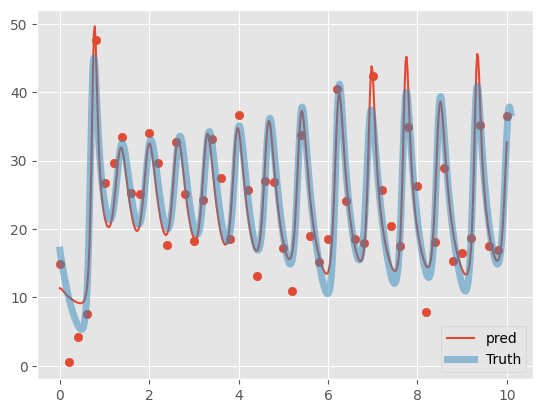

In [10]:
t_grid = jnp.linspace(0,10,500)
x_pred = model.predict_state(t_grid)

for i in range(3):
    plt.scatter(expdata.t_train,expdata.x_train[:,i])
    plt.plot(t_grid,x_pred[:,i],label = 'pred')
    plt.plot(expdata.t_true,expdata.x_true[:,i],lw = 5,alpha = 0.5,label = 'Truth')
    plt.legend()
    plt.show()